<a href="https://colab.research.google.com/github/mknomics/teaching/blob/main/Dummy_Variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.linear_model import LinearRegression

In [7]:
def model(X=True, Y=True):
  lm = LinearRegression()

  lm.fit(X,Y)
  Yhat = lm.predict(X)

  plt.figure()

  ax1 = sns.distplot(Y, hist=False, color="r", label="Actual Value")
  sns.distplot(Yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)

  plt.title('Actual vs Fitted Values for Price')
  plt.xlabel('Price (in dollars)')
  plt.ylabel('Proportion of Cars')

  plt.show()
  plt.close()
  return

## Load Data into Colab

In [2]:
house_data_path='https://raw.githubusercontent.com/data-doctors/kaggle-house-prices-advanced-regression-techniques/master/data/train.csv'
df_house=pd.read_csv(house_data_path) # invoke Pandas and use read_csv() method passing in the parameter of the csv location, in this case a url address
df_house.head(1) # Visually Inspect that it loaded correctly
df_house.info() # info() is prefered to .dtypes method because info() gives null counts and dtypes and does not cut the output shortd

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


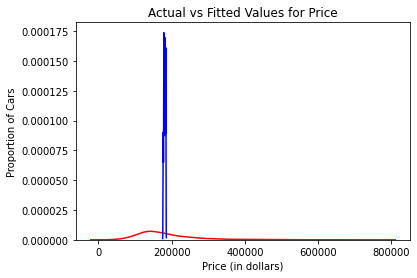

In [5]:
lm = LinearRegression()

X = df_house[['YrSold']]
Y = df_house['SalePrice']

lm.fit(X,Y)
Yhat = lm.predict(X)

plt.figure()

ax1 = sns.distplot(Y, hist=False, color="r", label="Actual Value")
sns.distplot(Yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Price (in dollars)')
plt.ylabel('Proportion of Cars')

plt.show()
plt.close()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


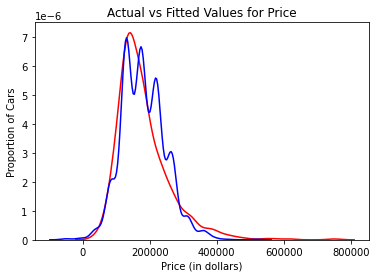

In [12]:
model(X=df_house[['LotArea','OverallQual']], Y=df_house['SalePrice'])

# Dummy Variables
Transform Categorical variables into "Dummy Variables".  Dummy Variables only take the value zero or one.  Lets consider the variable "BldgType" as an example.

Note the "BldgType" is an object datatype.  You can see this by typing:

```
df_house['BldgType'].dtype
```
This returns "O" for object, which we can easily see is a string that represents the type of building.  

How many categories does BldgType have?

Find this by typing:


```
df_house['BldgType'].unique()
```

Which returns: ['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs']

BldgType has 5 categories and we create 5 new columns of data, with the string category as the column name.  The values of each column will be 1 if that row is equal to the column name and zero otherwise.  

For example:  Suppose the first 5 rows of df_house['BldgType'] were:

'1Fam'

'1Fam'

'Duplex'

'TwnhsE'

'1Fam'


The Dummy variables would be: 

'1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'

1       0          0         0         0

1       0          0         0         0

0       0          1         0         0

0       0          0         1         0

1       0          0         0         0

## get_dummies()

In [15]:
pd.get_dummies(df_house['BldgType'])

,1Fam,2fmCon,Duplex,Twnhs,TwnhsE
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
1455,1,0,0,0,0
1456,1,0,0,0,0
1457,1,0,0,0,0
1458,1,0,0,0,0


## join dummies to original df

In [ ]:
df_house=pd.get_dummies(df_house['BldgType']).join(df_house)


In [26]:
df_house.head(2)

,1Fam,2fmCon,Duplex,Twnhs,TwnhsE,Id,MSSubClass,MSZoning,LotFrontage,LotArea,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,0,0,0,0,1,60,RL,65.0,8450,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,1,0,0,0,0,2,20,RL,80.0,9600,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


# Modeling with dummies

We can now include these dummies in our model but we have to watch out not to violate one of the most imporant conditions of our Regression model, which can be stated in the following non-technical terms:

The information of any given column must contain unique information.  If we include all dummy variables then we violate this condition.  How?

Consider a simple dummy variable, "Gender" which takes on two values for this discussion sake, "Male" and "Female".  If we make a dummy variable for Male and Female then notice that 

Male = 1 - Female

In other words, if you give me either column then I can tell you what the value of the second column is without even looking at it.  Full information on Gender is contained in a single column so adding a second column gives no new information. 

The technical jargon is that (𝐗ᵀ𝐗)^-1 is full rank, meaning that no column is a linear combination of other columns.  

**bottom line** You always have to exclude one category when adding dummy variables to your model and the dummy that you exclude should not be sparce (having only a few values of 1)

If you violate this then be prepared for wild results. 